In [1]:
# Refresh input modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
# Import Python packages
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from datetime import timedelta
from matplotlib.dates import DateFormatter




# Import setup file
from base_include import *
from get_model_data import *
from modelling_functions import *

AttributeError: 'DataFrame' object has no attribute 'date'

## Modelling
Retrain all the models using all data.

In [ ]:
# Set up a dictionary for all four models (grass, grass fdi, forest, forest fdi)
grass_incidents['is_train_data'] = 1
forest_incidents['is_train_data'] = 1
# features selected in variable_selection notebook
grass_2_hrs_features = ['T_SFC', 'T_SFC_ishistorical', 'RH_SFC', 'WindMagKmh_SFC', 'KBDI', 'ruggedness_average_3km', 'building_density_3km', 'road_density_km_in_3km', 'road_distance_m', 'forest_density_3km', 'shrub_density_3km', 'soil_moisture', 'Curing']
forest_4_hrs_features = ['T_SFC', 'KBDI', 'elevation_m', 'road_density_km_in_3km', 'road_distance_m', 'grass_density_3km', 'shrub_density_3km', 'noveg_density_3km', 'distance_to_interface', 'Curing']
grass_2_hrs_transform_features = ['ruggedness_average_3km', 'building_density_3km', 'road_density_km_in_3km', 'road_distance_m', 'shrub_density_3km', 'soil_moisture']
forest_4_hrs_transform_features = ['road_density_km_in_3km', 'road_distance_m', 'noveg_density_3km', 'distance_to_interface']

models = {
    'grass': {
        'incidents':grass_incidents,
        'outcome':'uncontrolled_within_2_hrs',
        'model_features':grass_2_hrs_features,
        'transform_features': grass_2_hrs_transform_features,
        'transforms':{key: 'np.log1p' for key in grass_2_hrs_transform_features},
    },
    'grass_fdi': {
        'incidents':grass_incidents.dropna(subset='GFDI'),
        'outcome':'uncontrolled_within_2_hrs',
        'model_features':['GFDI'],
        'transforms':{},
    },
    'forest': {
        'incidents':forest_incidents,
        'outcome':'uncontrolled_within_4_hrs',
        'model_features':forest_4_hrs_features,
        'transform_features': forest_4_hrs_transform_features,
        'transforms':{key: 'np.log1p' for key in forest_4_hrs_transform_features},
    },
    'forest_fdi': {
        'incidents':forest_incidents,
        'outcome':'uncontrolled_within_4_hrs',
        'model_features':['FFDI'],
        'transforms':{},
    },
}




Model grass 
Fraction of data used in training: 1.0
Num rows in train:  7580 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.325638
         Iterations 7


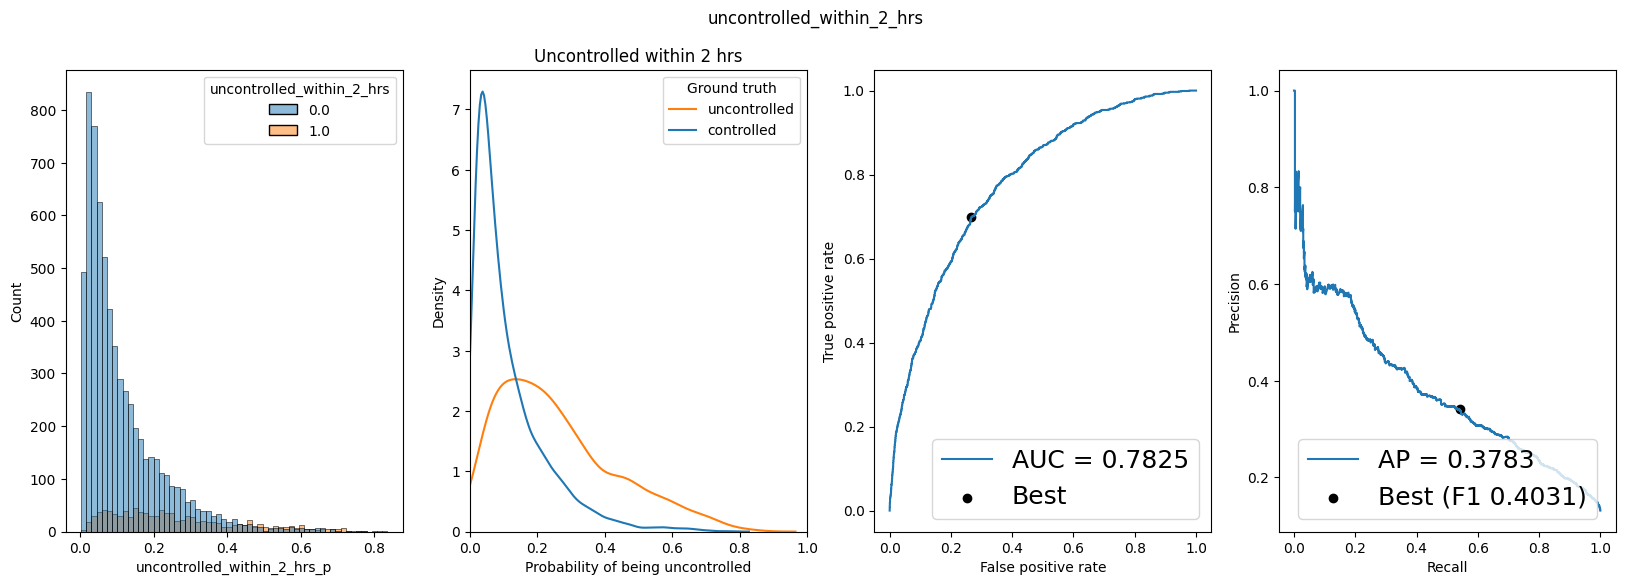

Model grass_fdi 
Fraction of data used in training: 1.0
Num rows in train:  7549 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.378233
         Iterations 6


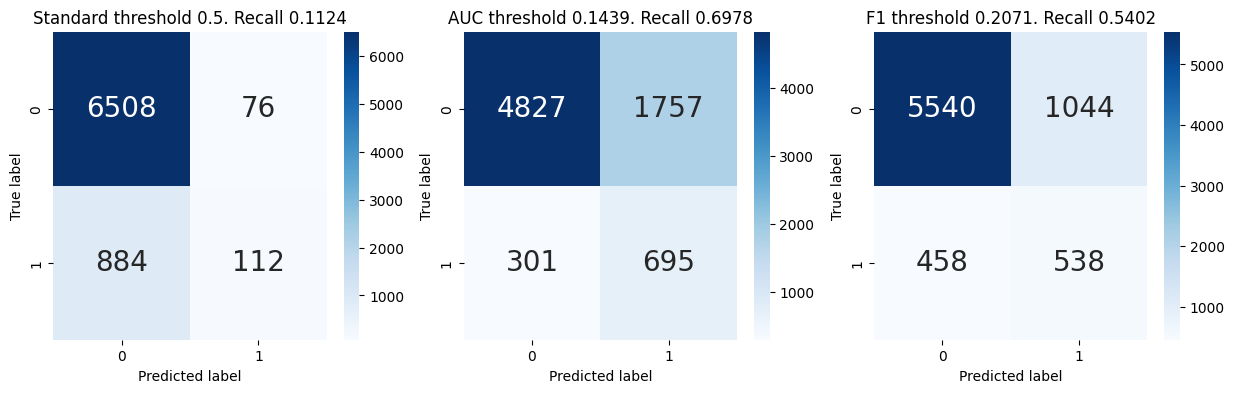

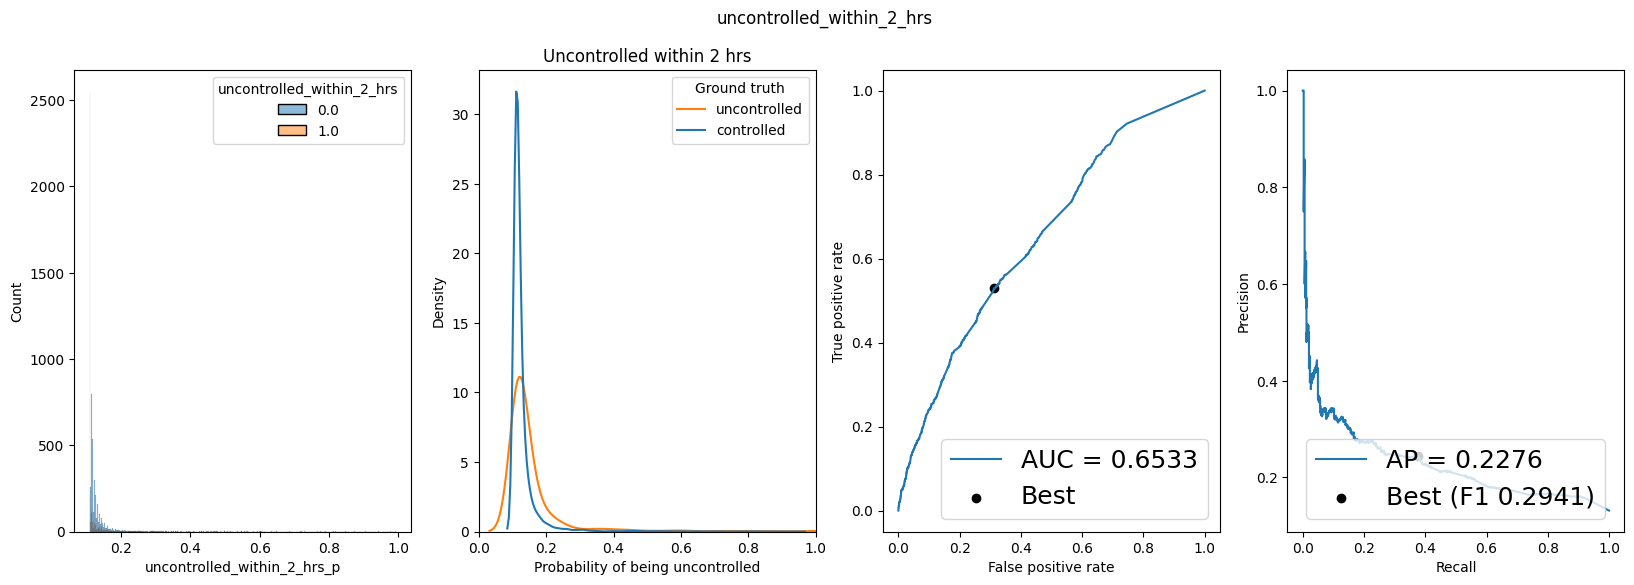

Model forest 
Fraction of data used in training: 1.0
Num rows in train:  3812 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.388758
         Iterations 7


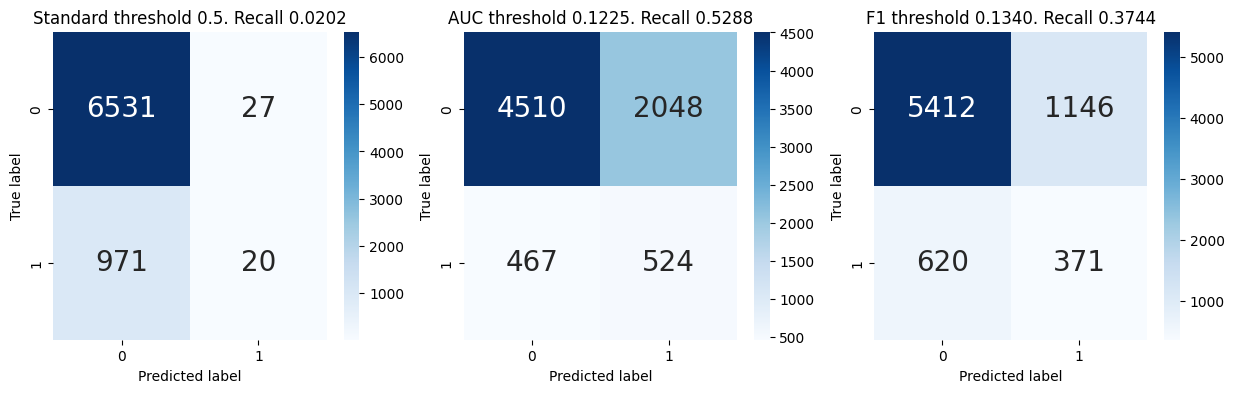

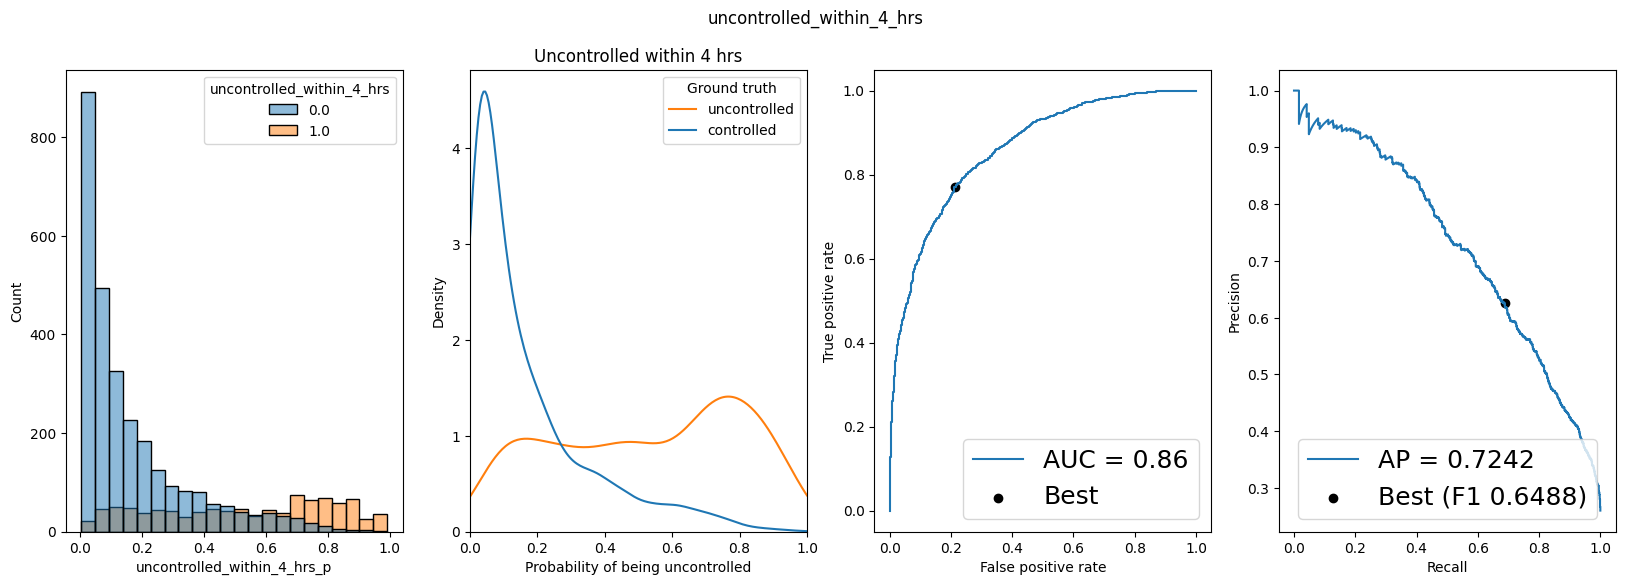

Model forest_fdi 
Fraction of data used in training: 1.0
Num rows in train:  3812 Num rows in test:  0
Optimization terminated successfully.
         Current function value: 0.571891
         Iterations 5


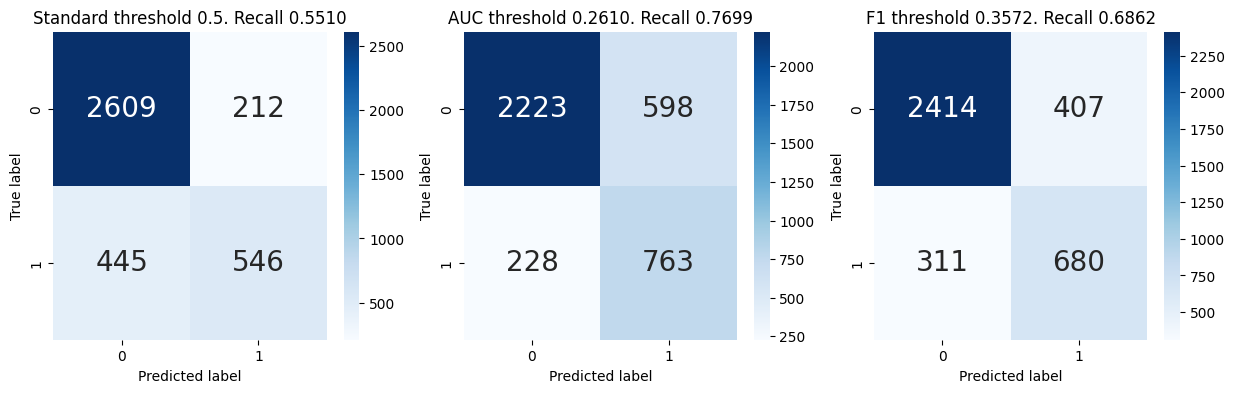

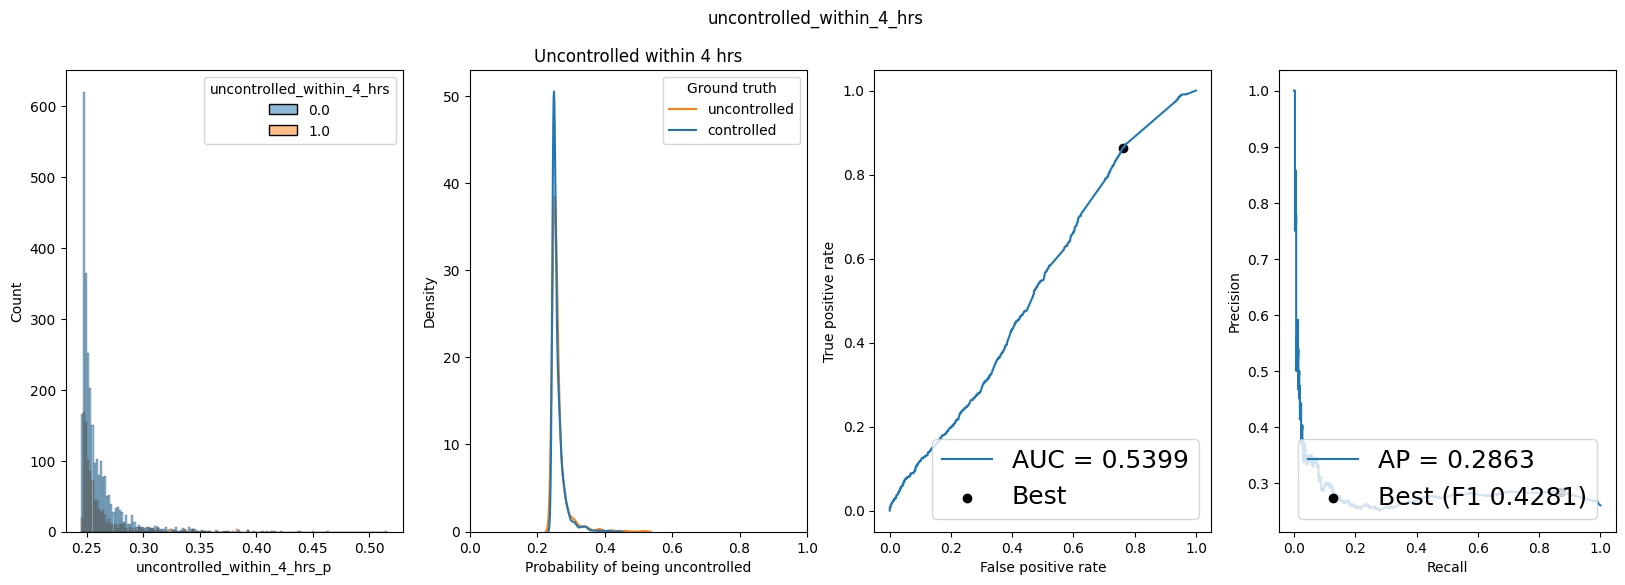

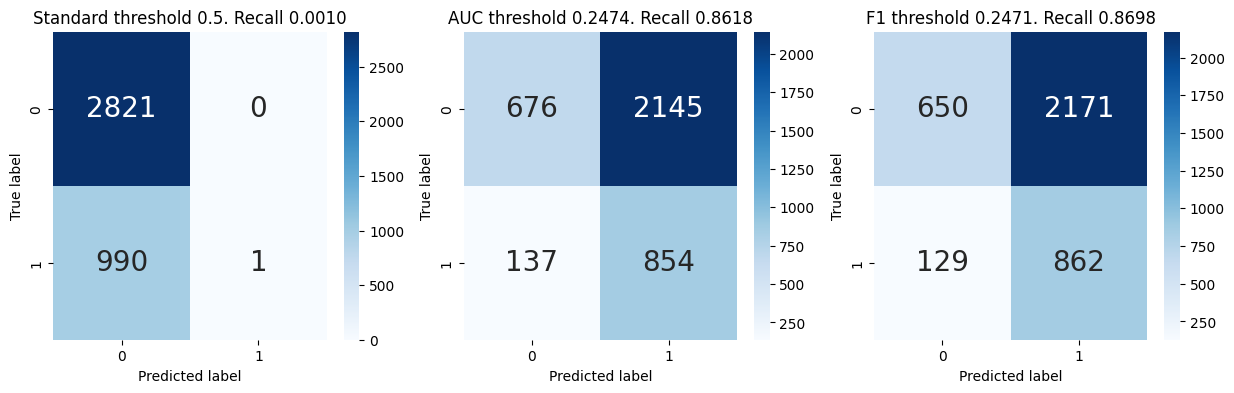

In [ ]:
# Build all the models and store the output in the dictionary.
for model in models.keys():
    print('Model {} '.format(model))
    models[model]['fit'] = fit_logistic_regression(
        models[model]['incidents'],
        models[model]['outcome'],
        model_features=models[model]['model_features'],
        transform=models[model]['transforms']
    )
    get_model_diagnostics(
        rslt = models[model]['fit'][0],
        incidents_train = models[model]['fit'][1],
        incidents_test = models[model]['fit'][1],
        outcome = models[model]['outcome'],
        print_diagnostics=True, 
        print_confusion_matrix=True
        )

# Case studies


### Define days

In [ ]:
# Make the test data just the days required (which are the rows with data in the date column).
for model in models.keys():
    models[model]['fit'] = list(models[model]['fit']) 
    incidents_test = models[model]['fit'][1].copy()
    incidents_test = incidents_test.dropna(subset='date')
    models[model]['fit'][2] = incidents_test


In [ ]:
# Create a combined dataset
for model in ['grass', 'forest']:
    outcome = models[model]['outcome']
    test_data = models[model]['fit'][2].copy()
    test_data['outcome_p'] = test_data[outcome+'_p']
    test_data['outcome'] = test_data[outcome]
    
    if model == 'grass':
        test_data_combined = test_data.copy()
    else:
        test_data_combined = pd.concat([test_data_combined, test_data])


test_data_combined['primary_fuel_type'] = test_data_combined['primary_fuel_type'].cat.remove_categories(['shrub', 'noveg'])

### Plots for paper

In [ ]:
annotations = {
    pd.Timestamp(dt(2009, 2, 7, 15, 32, 14)): '1',
    pd.Timestamp(dt(2009, 2, 7, 16, 35, 0)): '2',
    pd.Timestamp(dt(2009, 2, 7, 18, 5, 0)): '3',
    pd.Timestamp(dt(2009, 2, 7, 19, 30, 0)): '4',
    pd.Timestamp(dt(2018, 3, 17, 21, 21, 29)): '5',
    pd.Timestamp(dt(2019, 11, 21, 10, 0, 0)): '6',
    pd.Timestamp(dt(2019, 11, 21, 12, 32, 0)): '7',
    pd.Timestamp(dt(2019, 11, 21, 13, 0, 59)): '8',
    pd.Timestamp(dt(2019, 11, 21, 15, 18, 9)): '9',
    pd.Timestamp(dt(2019, 11, 21, 18, 33, 0)): '10',
    pd.Timestamp(dt(2023, 2, 17, 15, 23, 0)): '11',
    pd.Timestamp(dt(2023, 2, 17, 15, 28, 1)): '12',
    pd.Timestamp(dt(2023, 2, 17, 18, 19, 45)): '13',
}

test_data_combined['annotation'] = np.nan
test_data_combined['annotation'] = test_data_combined['reported_time'].map(annotations)

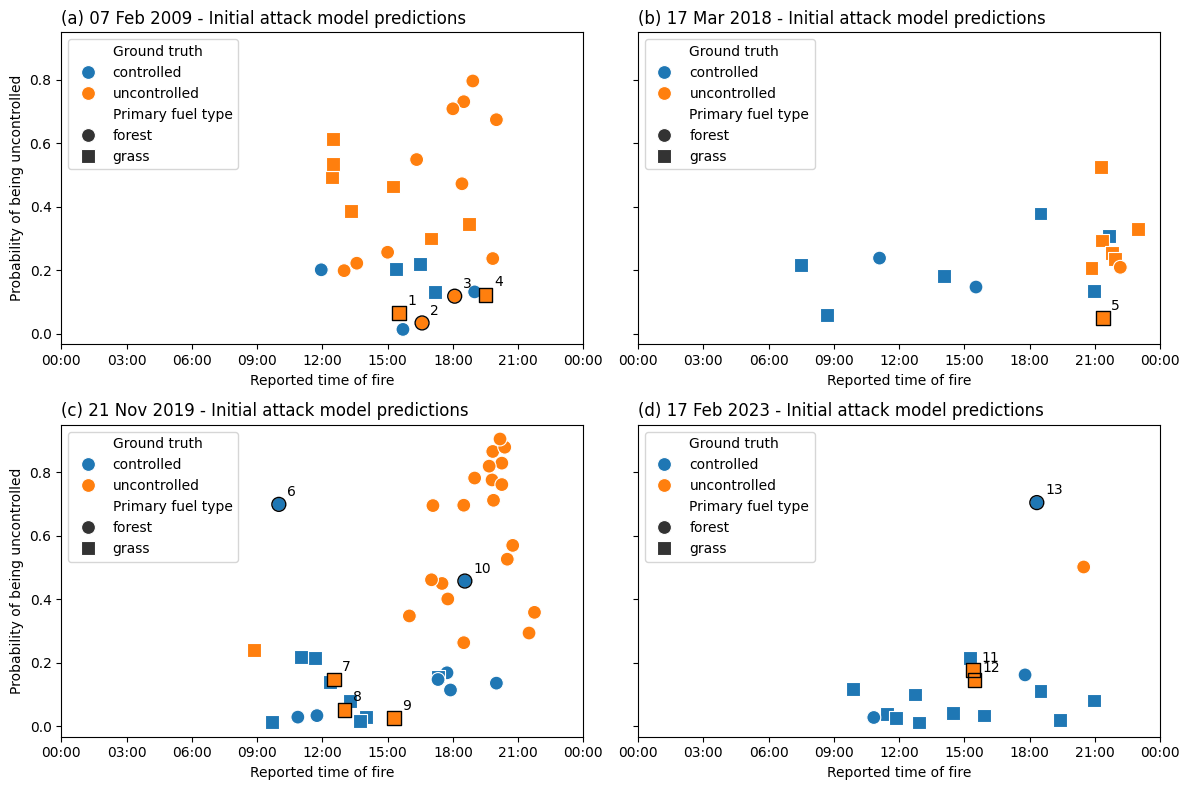

In [ ]:
# Days for case studies
days = incidents["date"].dropna().unique()
# Set up plot
fig, axs = plt.subplot_mosaic([['(a)', '(b)'], ['(c)', '(d)']], figsize=(12, 8), tight_layout=True, sharey=True)
date_ix=0
for i in ['(a)', '(b)', '(c)', '(d)']:
    day = days[date_ix]
    date_ix = date_ix + 1
    
    data = test_data_combined[test_data_combined['date']==day]
    data = (data
            .assign(**{'Ground truth': data['outcome'].map({1: 'uncontrolled', 0: 'controlled'}),
                        'Primary fuel type': data['primary_fuel_type']})
            .sort_values('outcome'))
    axs[i].xaxis.set_major_formatter(DateFormatter("%H:%M"))
    axs[i].set_title('{} {} - Initial attack model predictions'.format(i, day.strftime('%d %b %Y')), loc='left')
    axs[i].set_xlim(dt.combine(day, dt(1990,1,1,0,0,0).time()), dt.combine(day+timedelta(days=1), dt(1990,1,1,0,0,0).time()))

    # Add points
    sns.scatterplot(data = data, x='reported_time', y='outcome_p', style='Primary fuel type', markers=['o', 's'], hue='Ground truth', ax=axs[i], s=100)
    
    # Add annotations
    a_data = data[~(data['annotation'].isna())]
    sns.scatterplot(data = a_data, x='reported_time', y='outcome_p', style='Primary fuel type', 
                    markers=['o', 's'], ax=axs[i], edgecolors='black', linewidth=1, legend=False, s=100, facecolors='none')
    for xi, yi, text in zip(a_data['reported_time'], a_data['outcome_p'], a_data['annotation']):
        axs[i].annotate(text,
            xy=(xi, yi), xycoords='data',
            xytext=(6, 6), textcoords='offset points')


    axs[i].set_xlabel("Reported time of fire", fontsize=10)
    axs[i].set_ylabel("Probability of being uncontrolled", fontsize=10)

In [ ]:
fig.savefig('case_studies.png', format='png')
fig.savefig('butlertartaglia.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
